Smartmeter Data Science Challenge
=================================

This challenge is designed to test basic electrical engineering skills together
with data science techniques.

It involves a slimmed-down problem of non-intrusive load monitoring (NILM) for
smartmeter data measured in our office.

The data
--------

The data is a table of smartmeter measurements over 0.2 sec time intervals.  The
measured quantities (from a single AC phase) are:

  * `I_rms`: RMS current (in A)

  * `U_rms`: RMS voltage (in V)

  * `S`: apparent power (in VA)

  * `Q`: reactive power (in VA)

  * `P`: active power (in W)

  * `harmonic_I_NN`: the `NN`th harmonic of current, for 3rd, 5th and 7th
    harmonics of the AC frequency

The AC frequency of this data is 50 Hz, and the rating voltage is 230 V.

The challenge
-------------

Based on the provided data, answer the following questions:

  * Identify when in the time series devices are being turned on and
    off

  * How many distinct devices can be observed?  Can you map individual
    on/off events to the device?

      - you do not need to identify the _actual_ device, but rather
        to classify the events based on features in the dataset

  * Based on the different feature values associated with different
    devices, can you say anything about the kinds of device they are?
    (Give clear reasons for your answers.)

We recommend (but do not strictly require) that you implement your solution as
a Jupyter Notebook using Python, as this is the language our team uses most in
production.

Some requirements:

  * Try to write clean and clear code that a colleague would find a
    pleasure to maintain and modify (use code documentation as you
    see fit to aid in this)

  * Please document your work and ideas in a way that helps us clearly
    understand the reasons for your approach and the thinking behind
    any insights you obtain

Feel free to ask us whatever questions you like, just as if you were a colleague
working remotely.

* How would it change your approach if you would know that the switching time between on and off of a device is only a few milliseconds and that then power level would be stable?


In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import numpy as np
import ruptures as rpt
from scipy import signal
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [3]:
path = '/home/itai/Downloads/meter_data.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
df['timestamp'] = df['timestamp'].apply(lambda x: np.timedelta64(pd.Timestamp(x) -pd.Timestamp(df['timestamp'].iloc[0]),'ms').astype(np.int32))

In [6]:
df.head(5)

,timestamp,I_rms,U_rms,S,Q,P,harmonic_I_03,harmonic_I_05,harmonic_I_07
0,0,0.026616,238.914564,6.358997,4.107624,-1.103088,1.693918,2.364160,2.239170
1,189,0.022169,238.994721,5.298291,3.421000,-0.804425,2.711630,2.855956,1.912822
2,392,0.020819,239.176934,4.979447,3.722391,-0.704212,0.687889,3.624636,2.490151
3,595,0.026826,239.269831,6.418585,4.067994,-1.271494,4.530055,1.087715,3.392836
4,798,0.031124,239.261189,7.446851,3.810160,-1.343031,0.065944,2.000889,2.086636


In [7]:
P_np = np.array(df['P'])
res_filter =[x for x in range(0,9620) if (P_np[x-1]<0 and P_np[x]>10) or (P_np[x]>10 and P_np[x+1]<0)]
tup_list = [(res_filter[i],res_filter[i+1]) for i in range(0,len(res_filter),2)]

In [8]:
def difference(dataset, interval=1):
    """interval-lag auxiliary
        :parameters: 
                    dataset (DataFrame)
                    intervel (int)
        :returns: 
                    DataFrame of (intervel)-Lag."""
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff,columns=["derivative"])


def smoothing(dg,window):
    """moving average auxiliary
    :parameters: 
                dg: dataframe
                window: integer
    :returns moving average for dg with size window. """     
    rolling = dg.rolling(window=window)
    return rolling.mean()

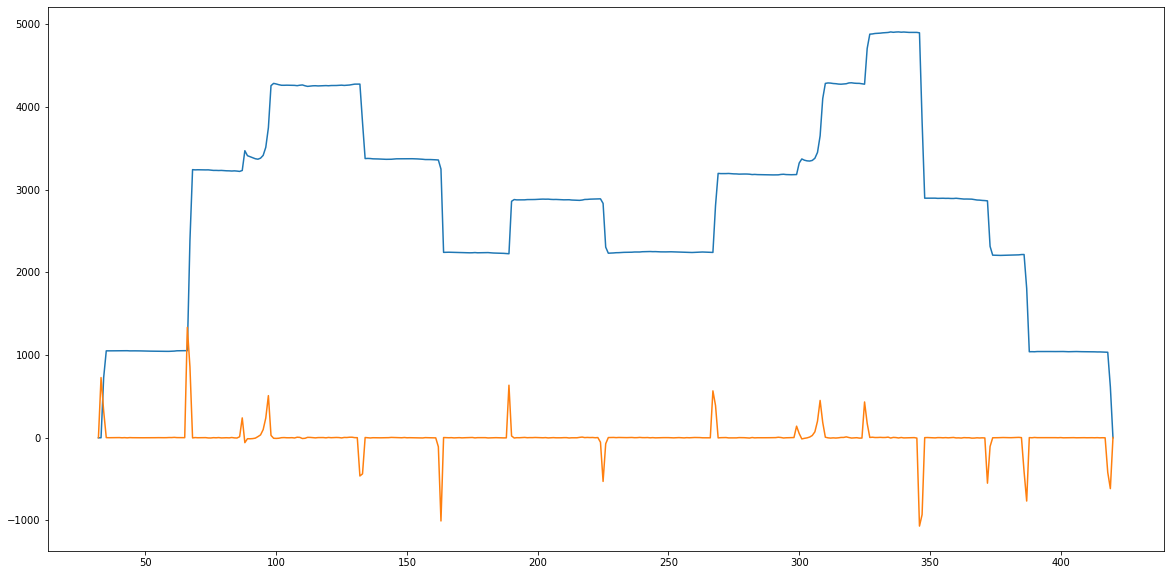

In [206]:
#interval (a,b):
(a,b) = tup_list[0][0]-2,tup_list[0][1]+2

plt.plot(df['P'][a:b])
plt.plot(difference(df['P'])[a:b])

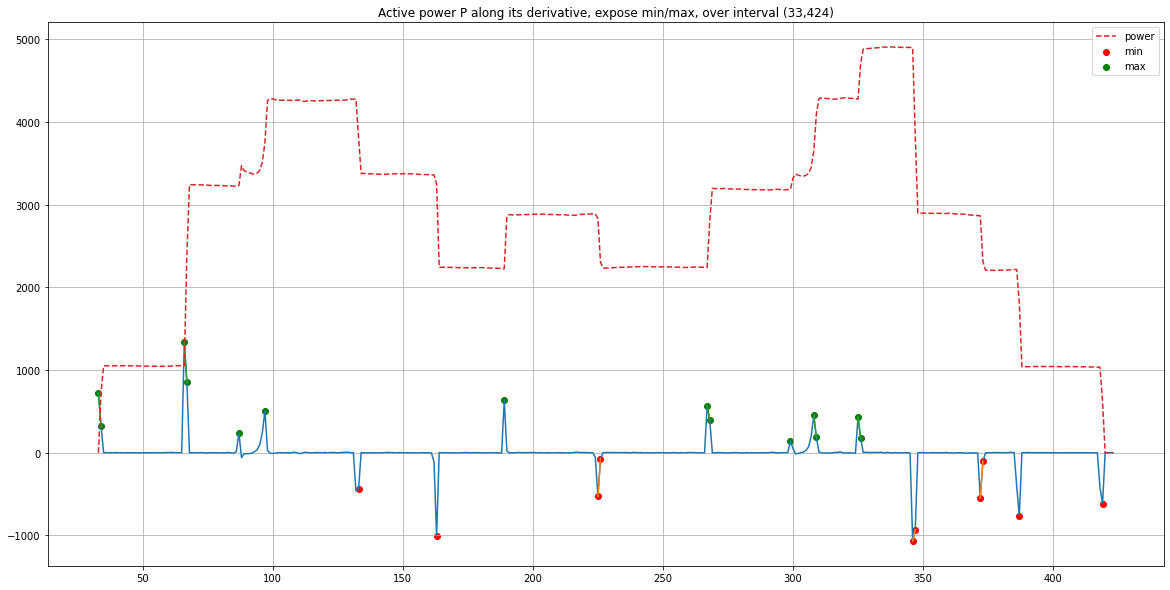

In [182]:
#compute derivative; show extremum. 
diff = difference(df['P'])

# refining parameter
k = 50

#min/max
diff['min'] = diff.loc[( -k > diff["derivative"]) & (diff["derivative"].shift(-1)-k > diff["derivative"])]
diff['max'] = diff.loc[(diff["derivative"].shift(-1) < diff["derivative"]-k) & (diff["derivative"] > k) ]["derivative"]

# plot results
plt.scatter(diff[a:b].index, diff['min'][a:b], c='r',label='min')
plt.scatter(diff[a:b].index, diff['max'][a:b], c='g',label='max')
plt.plot(diff[a:b])
plt.plot(df['P'][a:b],'--',label='power')
plt.grid(True)
plt.legend()
plt.title("Active power P along its derivative, expose min/max, over interval ({0},{1})".format(a,b))
plt.show()

# connecting adjuncts min/max points by adding values.

In [147]:
diff.head()

,derivative,min,max
0,0.298663,NaN,NaN
1,0.100213,NaN,NaN
2,-0.567282,NaN,NaN
3,-0.071537,NaN,NaN
4,-0.016924,NaN,NaN


In [148]:
def connect_adjuncts(diff):
    
    """procedure to modify the DataFrame diff, to connect all adjunct max/min points"""
    
    #prepering measures
    df_ons,df_offs = diff['max'],diff['min']
    df_ons.dropna(inplace = True)
    df_offs.dropna(inplace = True)
    df_ons = df_ons.reset_index()
    df_offs = df_offs.reset_index()
    adjunct_ind_on = df_ons.loc[df_ons.shift(-1)["index"]==df_ons["index"]+1]["index"].index.tolist()
    adjunct_ind_off = df_offs.loc[df_offs.shift(-1)["index"]==df_offs["index"]+1]["index"].index.tolist()
    
    
    #create a new DataFrame for the added max/min
    
    don_t = pd.DataFrame(columns=['index',"max"])
    for i in adjunct_ind_on:
        new_row = (df_ons.loc[i]["index"], df_ons.loc[i]['max'] + df_ons.loc[i+1]['max'])
        don_t = don_t.append({'index': new_row[0],'max':new_row[1]},ignore_index=True)
    
    don_t = don_t.astype({"index": int})
    
    doff_t = pd.DataFrame(columns=['index',"min"])
    for i in adjunct_ind_off:
        new_row = (df_offs.loc[i]["index"], df_offs.loc[i]['min'] + df_offs.loc[i+1]['min'])
        doff_t = doff_t.append({'index': new_row[0],'min':new_row[1]},ignore_index=True)
    
    doff_t = doff_t.astype({"index": int})
    
    df_ons_new = df_ons.loc[list(set(df_ons.index)-set(adjunct_ind_on + [x+1 for x in adjunct_ind_on]))]
    df_ons_new = df_ons_new.append(don_t).set_index("index").sort_index()
    
    df_offs_new = df_offs.loc[list(set(df_offs.index)-set(adjunct_ind_off + [x+1 for x in adjunct_ind_off]))]
    df_offs_new = df_offs_new.append(doff_t).set_index("index").sort_index()
    
    #reset index
    
    index = pd.RangeIndex(start=0, stop=diff.shape[0])
    
    df_offs_new = df_offs_new.reindex(index)
    df_ons_new = df_ons_new.reindex(index)
    
    return pd.concat([df_ons_new, df_offs_new],axis=1)

In [211]:
#make a plot.

def plot_interval(num,tup_list=tup_list, eta = 3, add_harmonic = False, modified = True):
    """:paramters: num - interval number
                   tuplist - list of tuples
                   eta - annotation parameter
        booleans:  add_harmonic - False (default) to omit harmonic plot 
                   modified - True (default) to modify derivative to sum together near extremums"""
    #extract interval 
    a,b = tup_list[num][0]-1,tup_list[num][1]+2
    #compute derivative according to the boolean "modified": 
    if modified: 
        d = connect_adjuncts(diff)
        title_predix_str = "MODIFIED:"
    else:
        d = diff
        title_predix_str = ""
    #scatter plot max,min
    plt.scatter(d[a:b].index, d['max'][a:b], c='r',label='max')
    plt.scatter(d[a:b].index, d['min'][a:b], c='g',label='min')
    #plot derivative
    plt.plot(diff[a:b])
    plt.plot(df['P'][a:b],'--',label='power')
    if add_harmonic:
        plt.plot(df['harmonic_I_03'][a:b],'--',label='harmonic_I_03')
    plt.grid(True)
    plt.legend()
    plt.title("{2} Active power P along its derivative, expose min/max, over interval ({0},{1})".format(a,b,title_predix_str))

    # add annotations
    x_max,y_max = d['max'][a:b].dropna().index.tolist(), d['max'][a:b].dropna().tolist()
    x_min,y_min = d['min'][a:b].dropna().index.tolist(), d['min'][a:b].dropna().tolist()

    for i in range(len(x_max)):
        plt.annotate(np.rint(y_max[i]), (x_max[i]+eta, y_max[i]+eta),fontsize=12)
    
    for i in range(len(x_min)):
        plt.annotate(np.rint(y_min[i]), (x_min[i]-eta, y_min[i]-eta),fontsize=12)

        
    plt.show()


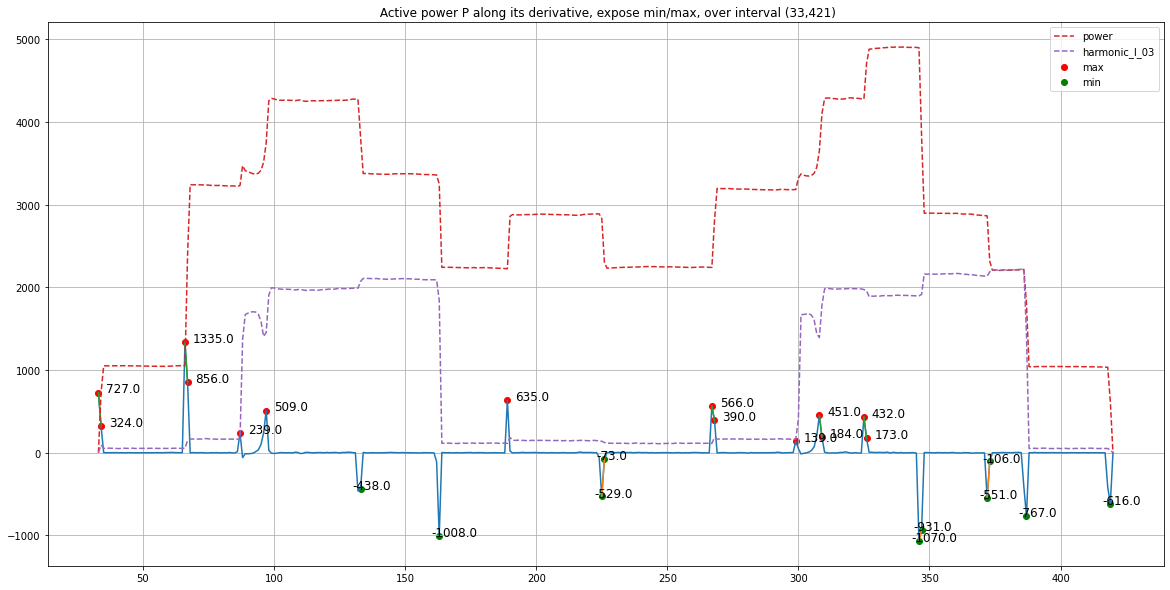

In [213]:
plot_interval(0,tup_list=tup_list,add_harmonic=True,modified= False)

* Assumption: every device which was turned on during an intervel, was eventually switched off. 

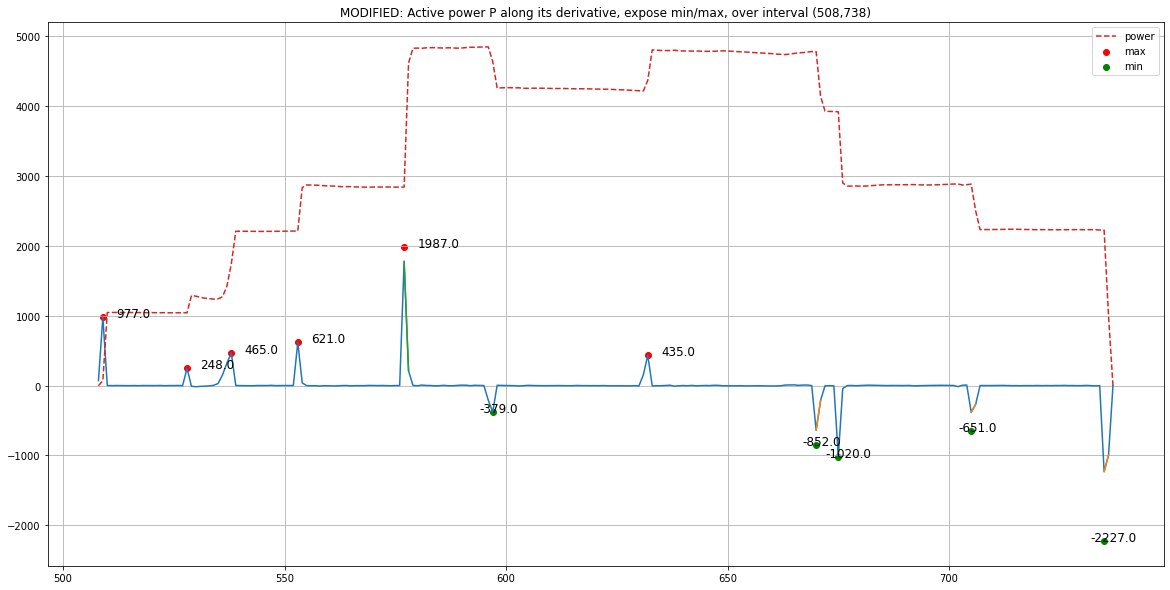

In [215]:
plot_interval(1,tup_list=tup_list)

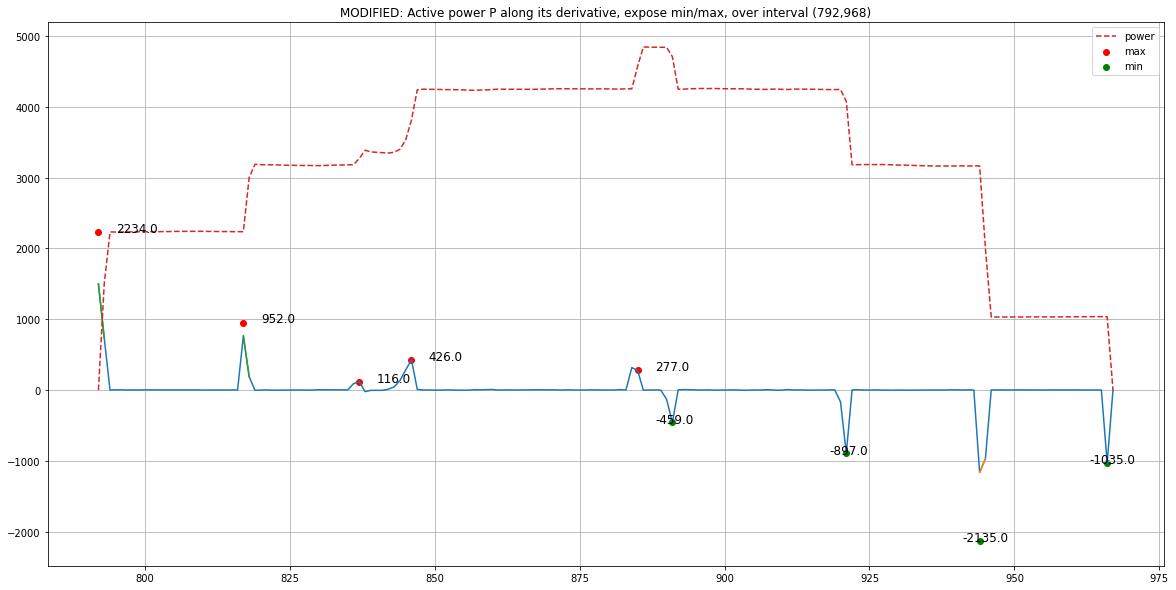

In [168]:
plot_interval(3,tup_list=tup_list)

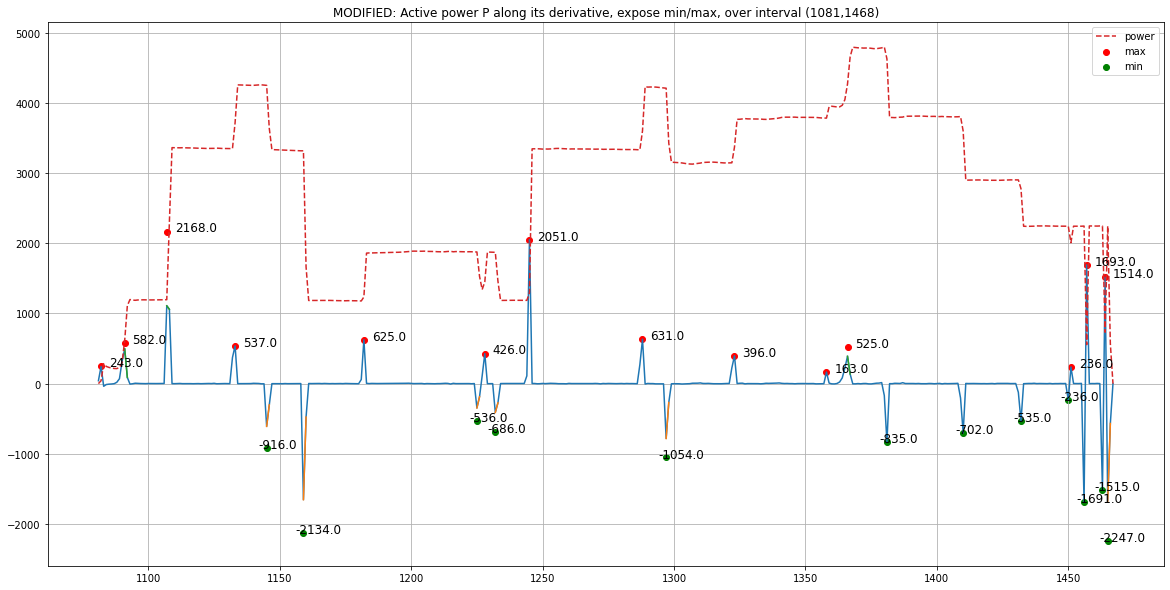

In [169]:
plot_interval(4,tup_list=tup_list)

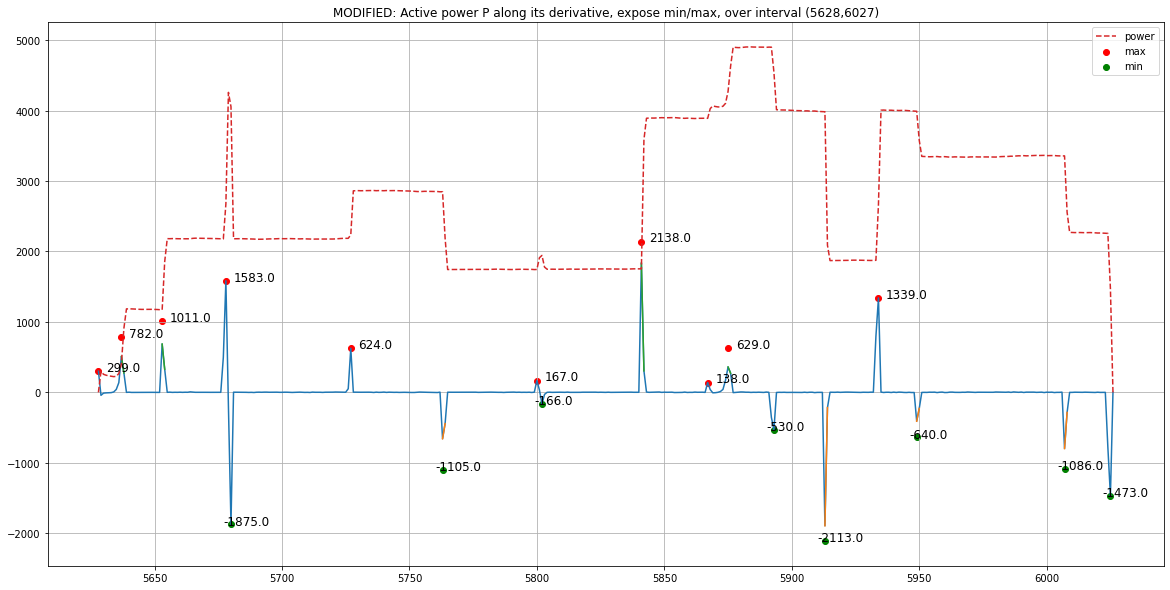

In [216]:
plot_interval(15,tup_list=tup_list)

In [323]:
def GaussianKernel(v1, v2, sigma):
    return np.exp(-np.linalg.norm(v1-v2)**2/(2.*sigma**2))


def matching_prediction(num,threshold=300):
    """we match switch ons to switch offs by computing euclidean distance with a gaussian kernel.
    :parameters: num (int) 
                threshold (int) for minimal consideration regarding distances.
    :returns pred a dictionary """
    
    #extract interval 
    a,b = tup_list[num][0]-1,tup_list[num][1]+2
    d = connect_adjuncts(diff)
    
    # variance for the gaussian kernel for the interval
    sigma = (b-a)/6
    
    #initiate prediction dictionary
    pred = {}
    
    #connect adjuncts extremum
    d = connect_adjuncts(diff)
    
    #extract extremum information
    x_max,y_max = d['max'][a:b].dropna().index.tolist(), d['max'][a:b].dropna().tolist()
    x_min,y_min = d['min'][a:b].dropna().index.tolist(), d['min'][a:b].dropna().tolist()
    
    l_max=list(zip(x_max,y_max))
    l_min=list(zip(x_min,y_min))
    
    #initiate distance matrix with zeros
    mat_dist = np.matrix(np.ones((len(x_max),len(x_min))) * np.inf)
    
    # loop over all maximum values
    for i,max_tup in enumerate(l_max):
        
        # exclude past minimum points since a switch on should precede a switch off.
        l_min_nominees = list(filter(lambda x: x[0]>max_tup[0] , l_min))
        
        # loop over all minimum values
        for j,min_tup in enumerate(l_min):
            if min_tup in l_min_nominees:
                # compute distance with Gaussian kernel
                mat_dist[i,j] = np.abs(max_tup[1]-np.abs(min_tup[1]))*(1-GaussianKernel(max_tup[0],min_tup[0],sigma)) 
    
    #we make the backword predictions by removing a cross i,j from the matrix corresponds to the minimal value. 
    while len(l_max) >=1:
        
        n_i,n_j = map(int,np.where(mat_dist == mat_dist.min()))
        
        if np.abs(l_max[n_i][1]-np.abs(l_min[n_j][1])) <= threshold: 
            pred[l_max[n_i]] = l_min[n_j]
        l_max.pop(n_i)
        l_min.pop(n_j)
        mat_dist = np.delete(mat_dist, n_i, 0)
        mat_dist = np.delete(mat_dist, n_j, 1)
        
        # stopping condition
        if len(l_min)*len(l_max) == 0:
            break

    return pred 
              
    

In [326]:
matching_prediction(4)

{(1228, 426.21382363742987): (1232, -686.2143028317332),
 (1133, 537.2059875688283): (1225, -536.2981318717243),
 (1457, 1692.9929047482356): (1463, -1514.921214278413),
 (1366, 525.2982308436694): (1432, -535.3558280930924),
 (1082, 243.35567731742145): (1450, -236.49179152511056),
 (1107, 2167.802915339847): (1159, -2134.4812492924425),
 (1182, 624.8117158279135): (1410, -701.5817618135848)}

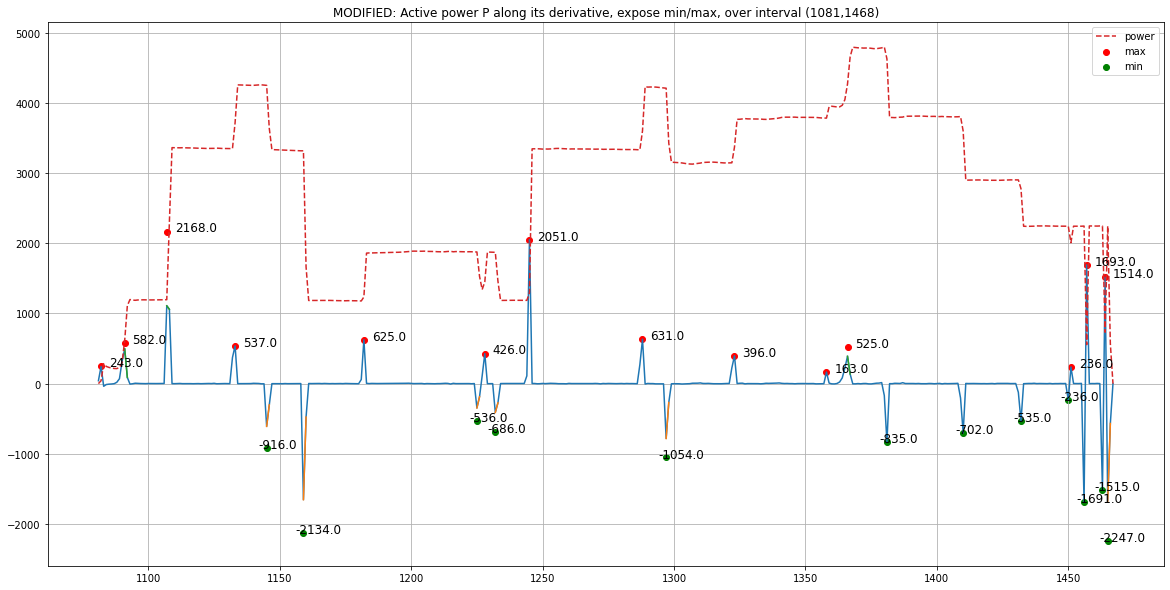

In [306]:
plot_interval(4)

In [328]:
matching_prediction(8)

{(3038, 2199.8588684067245): (3042, -2200.348944116726),
 (3025, 2078.922856239906): (3027, -2084.352478263332),
 (2848, 1017.1695695727644): (3005, -1009.9007364169711),
 (2990, 531.6847993554857): (3062, -502.44542058276727),
 (2931, 554.9343841748864): (2979, -476.47892138950283),
 (2834, 679.1275128372772): (2874, -485.4114451737869),
 (2820, 1025.158263448323): (2887, -927.5975888314429),
 (2918, 2105.2234592927366): (2959, -1892.15737911689)}

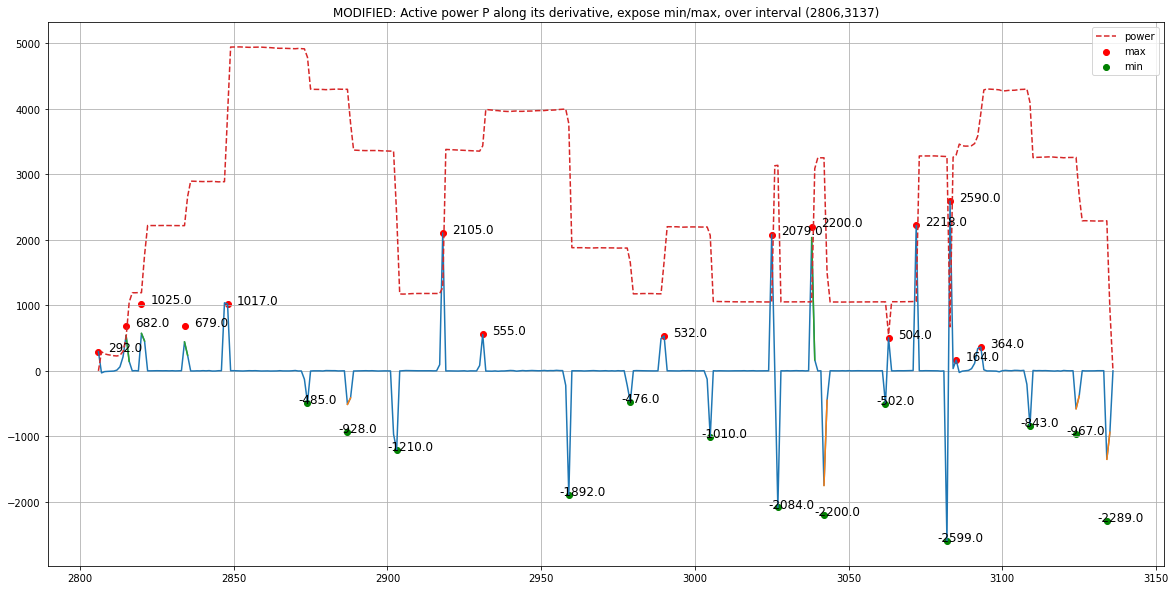

In [327]:
plot_interval(8)